In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

In [2]:
from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

In [3]:
from scipy.io import loadmat
from sklearn.utils import shuffle

In [4]:
from datetime import datetime

In [5]:
def error_rate(p, t):
    return np.mean(p!=t)

In [6]:
def relu(a):
    return a*(a>0)

In [8]:
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [9]:
def conv_pool(X, W, b, poolsize=(2,2)):
    conv_out = conv2d(input=X, filters=W)
    pool_out = pool.pool_2d(
        input=conv_out,
        ws=poolsize,
        ignore_border=True
    )

    return relu(pool_out + b.dimshuffle('x', 0, 'x', 'x'))

In [10]:
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

In [11]:
def rearrange(X):
    return (X.transpose(3, 2, 0, 1) / 255).astype(np.float32)

In [12]:
train = loadmat('./SVHN/train_32x32.mat')
test = loadmat('./SVHN/test_32x32.mat')

Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
del train
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)

Xtest = rearrange(test['X'])
Ytest = test['y'].flatten() - 1
del test
Ytest_ind = y2indicator(Ytest)

In [13]:
max_iter = 20
print_period = 10
lr = np.float32(0.00001)
reg = np.float32(0.01)
mu = np.float32(0.99)

In [14]:
N = Xtrain.shape[0]
batch_sz = 500
n_batch = N // batch_sz

In [15]:
M = 500
K = 10
poolsz = (2, 2)

In [16]:
W1_shape = (20, 3, 5, 5)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[0], dtype=np.float32)

W2_shape = (50, 20, 5, 5)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[0], dtype=np.float32)

W3_init = np.random.randn(W2_shape[0]*5*5, M) / np.sqrt(W2_shape[0]*5*5 + M)
b3_init = np.zeros(M, dtype=np.float32)

W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

X = T.tensor4('X', dtype='float32')
Y = T.matrix('T')

In [17]:
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')
W3 = theano.shared(W3_init.astype(np.float32), 'W3')
b3 = theano.shared(b3_init, 'b3')
W4 = theano.shared(W4_init.astype(np.float32), 'W4')
b4 = theano.shared(b4_init, 'b4')

dW1 = theano.shared(np.zeros(W1_init.shape, dtype=np.float32), 'dW1')
db1 = theano.shared(np.zeros(b1_init.shape, dtype=np.float32), 'db1')
dW2 = theano.shared(np.zeros(W2_init.shape, dtype=np.float32), 'dW2')
db2 = theano.shared(np.zeros(b2_init.shape, dtype=np.float32), 'db2')
dW3 = theano.shared(np.zeros(W3_init.shape, dtype=np.float32), 'dW3')
db3 = theano.shared(np.zeros(b3_init.shape, dtype=np.float32), 'db3')
dW4 = theano.shared(np.zeros(W4_init.shape, dtype=np.float32), 'dW4')
db4 = theano.shared(np.zeros(b4_init.shape, dtype=np.float32), 'db4')

In [18]:
Z1 = conv_pool(X, W1, b1)
Z2 = conv_pool(Z1, W2, b2)
Z3 = relu(Z2.flatten(ndim=2).dot(W3) + b3)
pY = T.nnet.softmax(Z3.dot(W4) + b4)

params = (W1, b1, W2, b2, W3, b3, W4, b4)
reg_cost = reg*np.sum((param*param).sum() for param in params)
cost = -(Y * T.log(pY)).sum() + reg_cost
prediction = T.argmax(pY, axis=1)

update_W1 = W1 + mu*dW1 - lr*T.grad(cost, W1)
update_b1 = b1 + mu*db1 - lr*T.grad(cost, b1)
update_W2 = W2 + mu*dW2 - lr*T.grad(cost, W2)
update_b2 = b2 + mu*db2 - lr*T.grad(cost, b2)
update_W3 = W3 + mu*dW3 - lr*T.grad(cost, W3)
update_b3 = b3 + mu*db3 - lr*T.grad(cost, b3)
update_W4 = W4 + mu*dW4 - lr*T.grad(cost, W4)
update_b4 = b4 + mu*db4 - lr*T.grad(cost, b4)

update_dW1 = mu*dW1 - lr*T.grad(cost, W1)
update_db1 = mu*db1 - lr*T.grad(cost, b1)
update_dW2 = mu*dW2 - lr*T.grad(cost, W2)
update_db2 = mu*db2 - lr*T.grad(cost, b2)
update_dW3 = mu*dW3 - lr*T.grad(cost, W3)
update_db3 = mu*db3 - lr*T.grad(cost, b3)
update_dW4 = mu*dW4 - lr*T.grad(cost, W4)
update_db4 = mu*db4 - lr*T.grad(cost, b4)

train = theano.function(
    inputs=[X, Y],
    updates=[
        (W1, update_W1),
        (b1, update_b1),
        (W2, update_W2),
        (b2, update_b2),
        (W3, update_W3),
        (b3, update_b3),
        (W4, update_W4),
        (b4, update_b4),
        (dW1, update_dW1),
        (db1, update_db1),
        (dW2, update_dW2),
        (db2, update_db2),
        (dW3, update_dW3),
        (db3, update_db3),
        (dW4, update_dW4),
        (db4, update_db4)
    ]
)

get_prediction = theano.function(
    inputs= [X,Y],
    outputs = [cost, prediction]
)

In [19]:
t0 = datetime.now()
LL = []
for i in range(max_iter):
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    for j in range(n_batch):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz+batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz+batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print('Cost/err at iteration: i={}, j={}: {:.3f}/{:.3f}'.format(i,j,cost_val, err) )
            LL.append(cost_val)
print('Elapsed time: {}'.format(datetime.now() - t0))

Cost/err at iteration: i=0, j=0: 59816.527/0.910
Cost/err at iteration: i=0, j=10: 58998.895/0.804
Cost/err at iteration: i=0, j=20: 58888.539/0.804
Cost/err at iteration: i=0, j=30: 58366.440/0.808
Cost/err at iteration: i=0, j=40: 58836.900/0.810
Cost/err at iteration: i=0, j=50: 58672.834/0.804
Cost/err at iteration: i=0, j=60: 58336.789/0.804
Cost/err at iteration: i=0, j=70: 58042.883/0.804
Cost/err at iteration: i=0, j=80: 57920.852/0.804
Cost/err at iteration: i=0, j=90: 58002.153/0.804
Cost/err at iteration: i=0, j=100: 58035.171/0.804
Cost/err at iteration: i=0, j=110: 57983.305/0.804
Cost/err at iteration: i=0, j=120: 57932.001/0.804
Cost/err at iteration: i=0, j=130: 57904.860/0.804
Cost/err at iteration: i=0, j=140: 57907.152/0.804
Cost/err at iteration: i=1, j=0: 57916.005/0.804
Cost/err at iteration: i=1, j=10: 57933.854/0.804
Cost/err at iteration: i=1, j=20: 57941.020/0.804
Cost/err at iteration: i=1, j=30: 57940.271/0.804
Cost/err at iteration: i=1, j=40: 57934.187/0.8

Cost/err at iteration: i=10, j=130: 57901.413/0.804
Cost/err at iteration: i=10, j=140: 57908.237/0.804
Cost/err at iteration: i=11, j=0: 57911.842/0.804
Cost/err at iteration: i=11, j=10: 57916.241/0.804
Cost/err at iteration: i=11, j=20: 57913.407/0.804
Cost/err at iteration: i=11, j=30: 57908.456/0.804
Cost/err at iteration: i=11, j=40: 57903.097/0.804
Cost/err at iteration: i=11, j=50: 57899.547/0.804
Cost/err at iteration: i=11, j=60: 57896.259/0.804
Cost/err at iteration: i=11, j=70: 57891.654/0.804
Cost/err at iteration: i=11, j=80: 57888.713/0.804
Cost/err at iteration: i=11, j=90: 57888.199/0.804
Cost/err at iteration: i=11, j=100: 57890.230/0.804
Cost/err at iteration: i=11, j=110: 57891.700/0.804
Cost/err at iteration: i=11, j=120: 57895.342/0.804
Cost/err at iteration: i=11, j=130: 57901.214/0.804
Cost/err at iteration: i=11, j=140: 57907.934/0.804
Cost/err at iteration: i=12, j=0: 57911.497/0.804
Cost/err at iteration: i=12, j=10: 57915.857/0.804
Cost/err at iteration: i=1

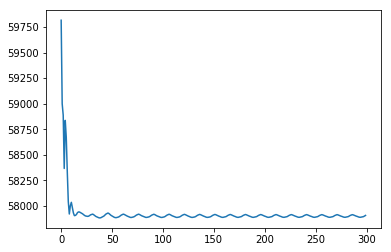

In [20]:
plt.plot(LL)
plt.show()

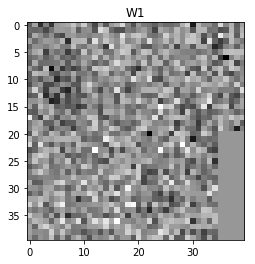

In [21]:
# visualize 1
W1_val = W1.get_value()
grid = np.zeros((8*5, 8*5))
m = 0
n = 0
for i in range(20):
    for j in range(3):
        filt = W1_val[i, j]
        grid[m*5:(m+1)*5, n*5:(n+1)*5] = filt
        m += 1
        if m >= 8:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title('W1')
plt.show()

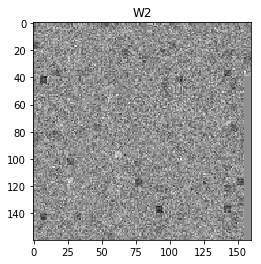

In [22]:
# visualize 2
W2_val = W2.get_value()
grid = np.zeros((32*5, 32*5))
m = 0
n = 0
for i in range(50):
    for j in range(20):
        filt = W2_val[i, j]
        grid[m*5:(m+1)*5, n*5:(n+1)*5] = filt
        m += 1
        if m >= 32:
            m = 0
            n += 1
plt.imshow(grid, cmap='gray')
plt.title('W2')
plt.show()